https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [1]:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from  tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "../input/"


In [2]:
app_train = pd.read_csv(path + "application_train.csv")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
bureau = pd.read_csv(path + "bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
bureau_balance = pd.read_csv(path + "bureau_balance.csv")
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [5]:
credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [6]:
pcb = pd.read_csv(path + "POS_CASH_balance.csv")
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [7]:
previous_application = pd.read_csv(path + "previous_application.csv")
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
installments_payments = pd.read_csv(path + "installments_payments.csv")
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## 学習データ準備

In [9]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

# read the test files 
app_test = pd.read_csv('../input/application_test.csv')

app_test['is_test'] = 1 
app_test['is_train'] = 0
app_train['is_test'] = 0
app_train['is_train'] = 1

# target variable
Y = app_train['TARGET']
train_X = app_train.drop(['TARGET'], axis = 1)

# test ID
test_id = app_test['SK_ID_CURR']
test_X = app_test

# merge train and test datasets for preprocessing
data = pd.concat([train_X, test_X], axis=0)

### カテゴリカルデータ処理

In [10]:
# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

# get categorical features
data_cats = _get_categorical_features(data)
prev_app_cats = _get_categorical_features(previous_application)
bureau_cats = _get_categorical_features(bureau)
pcb_cats = _get_categorical_features(pcb)
ccbal_cats = _get_categorical_features(credit_card_balance)

# create additional dummy features - 
previous_application = _get_dummies(previous_application, prev_app_cats)
bureau = _get_dummies(bureau, bureau_cats)
pcb = _get_dummies(pcb, pcb_cats)
credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

# factorize the categorical features from train and test data
data = _factorize_categoricals(data, data_cats)

## feature engineering

### <a id="1.1">1.1 Feature Engineering - Previous Applications</a>

In [11]:
## More Feature Ideas Reference : https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm 

## count the number of previous applications for a given ID
prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.2">1.2 Feature Engineering - Bureau Data</a>

In [12]:
# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')


### <a id="1.3">1.3 Feature Engineering - Previous Installments</a>

In [13]:
## count the number of previous installments
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## Average values for all other variables in installments payments
avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.4">1.4 Feature Engineering - Pos Cash Balance</a>

In [14]:
### count the number of pos cash for a given ID
pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pcb['SK_ID_PREV'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

## Average Values for all other variables in pos cash
pcb_avg = pcb.groupby('SK_ID_CURR').mean()
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.5">1.5 Feature Engineering - Credit Card Balance </a>

In [15]:
### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.6">1.6 Prepare Final Train and Test data</a>

In [16]:
#### prepare final Train X and Test X dataframes 
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### <a id="2.1">2.1 StratifiedKFold, GridSearch</a>

In [17]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
max_score = -100
max_params = None

list_auc_score = []

for train_idx, valid_idx in cv.split(trainX, Y):
    trn_x = trainX.iloc[train_idx, :]
    val_x = trainX.iloc[valid_idx, :]
    
    trn_y = Y[train_idx]
    val_y = Y[valid_idx]
    
    lgb_train = lgb.Dataset(data=trn_x, label=trn_y)
    lgb_eval = lgb.Dataset(data=val_x, label=val_y)
    
    params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.1, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
    model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
    preds = model.predict(val_x)
    auc = roc_auc_score(val_y, preds)
    list_auc_score.append(auc)
    if (max_score < auc):
        max_score = auc
    
    
sc_auc_score = np.mean(list_auc_score)
print(sc_auc_score, max_score)

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775584
Early stopping, best iteration is:
[124]	valid_0's auc: 0.776015
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.774796
Early stopping, best iteration is:
[153]	valid_0's auc: 0.775222
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.776658
Early stopping, best iteration is:
[165]	valid_0's auc: 0.777173
0.7761363870302557 0.7771727481853812


In [27]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
max_score = -100
max_params = None
max_lgb_train = None
max_lgb_eval = None

all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
          'learning_rate': [0.1], 'num_leaves': [48], 'num_iteration': [5000], 'verbose': [0] ,
          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[7], 'reg_alpha':[0.1], 'reg_lambda':[0.1], 
          'min_split_gain':[0.01], 'min_child_weight':[1]}

list_auc_score = []
list_preds = []

for param in tqdm(list(ParameterGrid(all_params))):
    for train_idx, valid_idx in cv.split(trainX, Y):
        trn_x = trainX.iloc[train_idx, :]
        val_x = trainX.iloc[valid_idx, :]
    
        trn_y = Y[train_idx]
        val_y = Y[valid_idx]
    
        lgb_train = lgb.Dataset(data=trn_x, label=trn_y)
        lgb_eval = lgb.Dataset(data=val_x, label=val_y)
    
        model = lgb.train(param, lgb_train,  valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
        preds_val = model.predict(val_x)
        preds = model.predict(testX)
        list_preds.append(preds)
        auc = roc_auc_score(val_y, preds_val)
        list_auc_score.append(auc)
        if (max_score < auc):
            max_score = auc
            max_params = param
            max_lgb_train = lgb_train
            max_lgb_eval = lgb_eval
    
sc_auc_score = np.mean(list_auc_score)
print(sc_auc_score, max_score)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.775584
Early stopping, best iteration is:
[124]	valid_0's auc: 0.776015
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.774054
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.77531



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:37<00:00, 97.42s/it]


0.7751263194275047 0.7760145450119765


### <a id="4.1">4.1 Feature Importance </a>

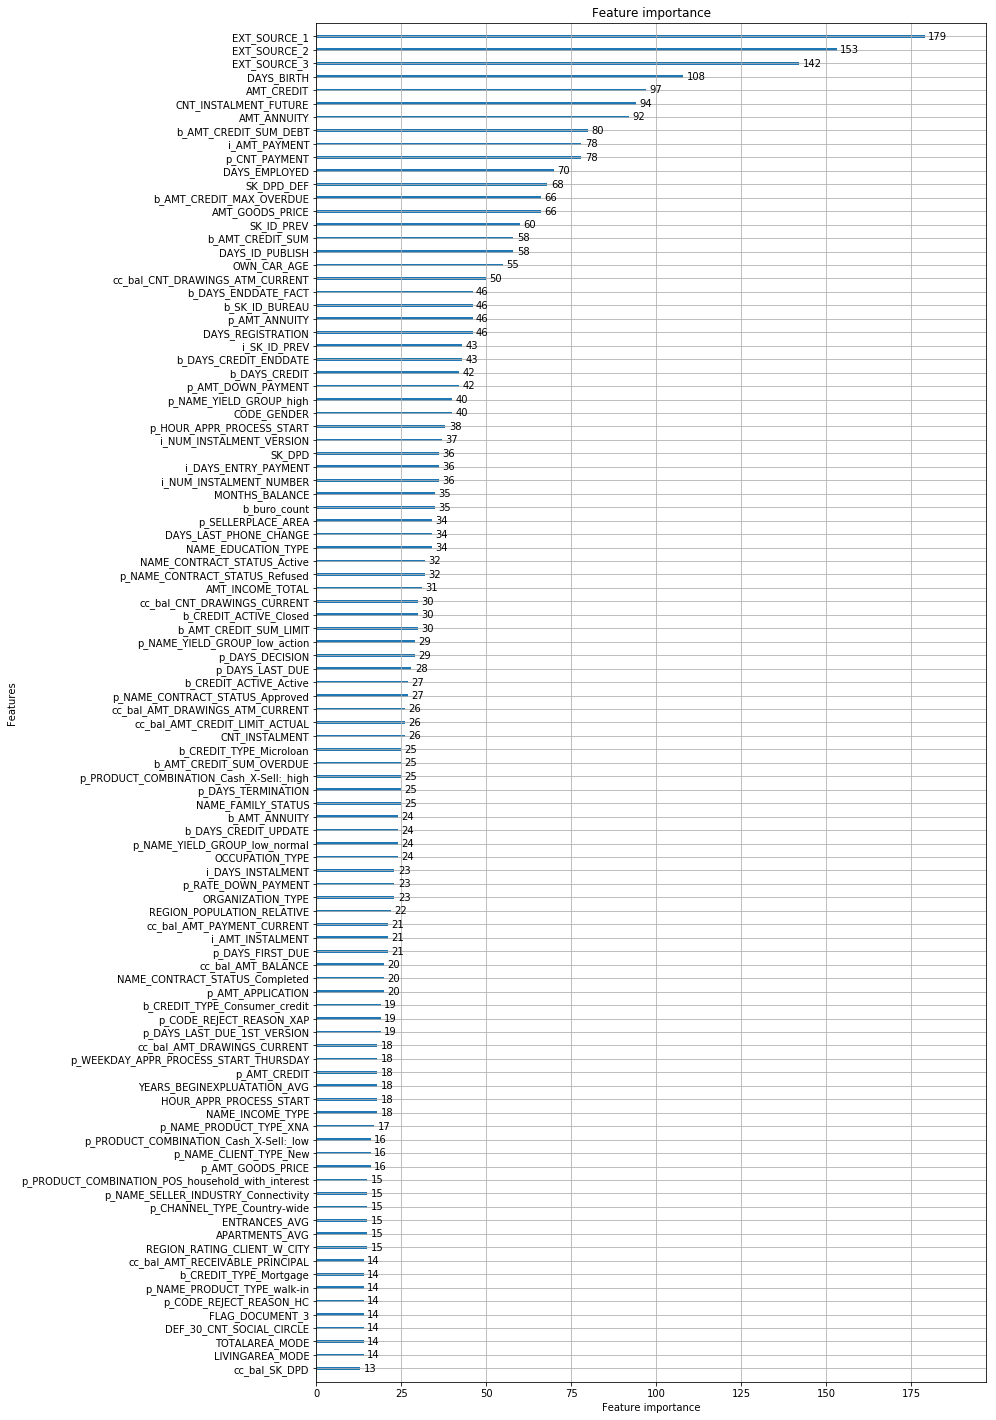

In [28]:
lgb.plot_importance(model, figsize=(12, 25), max_num_features=100);


### <a id="5.1">5.1 Predict</a>

In [34]:
preds = np.mean(list_preds, axis=0)

#preds = None
#for i in list_preds:
#    preds = preds + list_preds[i].values * 0.2

#final_lgb_train = lgb.Dataset(data=trainX, label=Y)
#final_model = lgb.train(max_params, final_lgb_train, lgb_eval, early_stopping_rounds=150, verbose_eval=200)
#preds = final_model.predict(testX, )

#clf_all = lgb.LGBMClassifier(random_state=0,n_jobs=-1,verbose=2, learning_rate=0.01, max_depth=max_params['max_depth'], num_leaves=max_params['num_leaves'], ta
#                             task = 'train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'],)
#clf_all.fit(trainX, Y.values.ravel())
#preds = clf_all.predict(testX)
    
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("../output/my_first_submit.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.046652
1,100005,0.124829
2,100013,0.018515
3,100028,0.028612
4,100038,0.197308


In [35]:
list_preds

[array([0.04306563, 0.13604316, 0.01296012, ..., 0.0170822 , 0.05078772,
        0.16354277]),
 array([0.0658904 , 0.11143652, 0.01716202, ..., 0.01068679, 0.07343807,
        0.20887918]),
 array([0.03099898, 0.12700857, 0.02542262, ..., 0.01565657, 0.05786507,
        0.17408813])]

In [ ]:
#X_pred= gbm.predict(np.array(xs_test), num_iteration=gbm.best_iteration)

In [30]:
list_preds

[array([0.04306563, 0.13604316, 0.01296012, ..., 0.0170822 , 0.05078772,
        0.16354277]),
 array([0.0658904 , 0.11143652, 0.01716202, ..., 0.01068679, 0.07343807,
        0.20887918]),
 array([0.03099898, 0.12700857, 0.02542262, ..., 0.01565657, 0.05786507,
        0.17408813])]